# An application of computer Vision with MNIST digit recognition Challenge. (~99.60% Accuracy)


### Table of interest:
1. Introduction
2. Import and Preprocess the data
3. Visualize some examples from the dataset.
4. Defining the model architecture Using ConVnets
5. Train the model without data augmentation
6. Train the model using data augmentation
7. Evaluate the model
8. Prediction
9. Submition

## 1. Introduction.

This is my first project on Kaggle and is done mainly for myself, for my personal experimentation of computer vision problem and CNN architectures. I hope that it might be helpful for others.
I'm trying to Experiment a LeNet architecture of CNN on MNIST digit dataset. For this purpuse, this notebook is inspired of many kaggle Kernel and many others papers which ares availlable on web, especially this one : <a href = "www.packtpub.com">Deep Learning with Keras</a>.

MNIST is called Hello world of Deep learning.


Let's get started.

## 2. Import and Preprocess the data

### Import all required libraries

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense , Dropout ,Flatten, Conv2D, MaxPooling2D, Activation
from keras.optimizers import Adam ,RMSprop
from keras import  backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

### Import of data

In [ ]:
train=pd.read_csv('../input/digit-recognizer/train.csv')
test=pd.read_csv('../input/digit-recognizer/test.csv')

print(train.shape)
print(test.shape)


### preprocess of data.

To conserve the spatial structure and relations of each image, we need to reshape image in dataset in 3 dimension (height = 28px, width = 28px , canal = 1). In particular, we transforms a flat vector representing each written digit into the bitmap representation for having the spatial locality of image.

In [ ]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)

# free some space
del train 

print(X_train.shape)
print(Y_train.shape)

# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

# reshaping the dataset
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

print(X_train.shape)
print(test.shape)

The output variable is an integer from 0 to 9. This is a multiclass classification problem. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]). 


In [ ]:
Y_train = to_categorical(Y_train, num_classes = 10)

## 3. Visualize some examples from the dataset.

Lets vizualise some images from dataset. 

In [ ]:
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i][:,:,0])

## 4. Defining the model architecture Using ConVnets

   Yann le Cun proposed (for more information refer to: ***Convolutional Networks for Images, Speech,
and Time-Series, by Y. LeCun and Y. Bengio, brain theory neural networks, vol. 3361, 1995***) a family
of ConvNets named LeNet trained for recognizing MNIST handwritten characters with robustness to
simple geometric transformations and to distortion. The key intuition here is to have low-layers
alternating convolution operations with max-pooling operations. The convolution operations are
based on carefully chosen local receptive fields with shared weights for multiple feature maps. Then,
higher levels are fully connected layers based on a traditional MLP with hidden layers and softmax as
the output layer.


   To define LeNet code, we use a convolutional 2D module, which is:
`keras.layers.convolutional.Conv2D(filters, kernel_size, padding='valid')`

**Here :**
* `filters` : is the number of convolution kernels to use (for example, the dimensionality of the output);
* `kernel_size` :  is an integer or tuple/list of two integers, specifying the width and height of the 2D convolution window (can be a single integer to specify the same value for all spatial dimensions);
* `padding='same'` means that padding is used. There are two options: `padding='valid'` means that the convolution is only computed where the input and the filter fully overlap, and therefore the output is smaller than the input, while `padding='same'` means that we have an output that is the same size as the input, for which the area around the input is padded with zeros.

In addition, we use a `MaxPooling2D` module:
`keras.layers.pooling.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))`

**Here :**
* `pool_size=(2, 2)` is a tuple of two integers representing the factors by which the image is vertically and horizontally downscaled. So (2, 2) will halve the image in each dimension;
* `strides=(2, 2)` is the stride used for processing.

Then we define the LeNet network:

* We have a first **convolutional** stage with `relu` activations followed by a **max-pooling**. Our net will learn `20` convolutional filters, each one of which has a size of `5 x 5`.The output dimension is the same one of the `input_shape`, so it will be `28 x 28`. Note that since the Convolution2D is the first stage of our pipeline, we are also required to define its `input_shape` . The max-pooling operation implements a sliding window that slides over the layer and takes the maximum of each region with a step of two pixels vertically and horizontally.

* Then a second **convolutional** stage with `relu` activations follows, again by a **max-pooling**. In this case, we increase the number of convolutional filters learned to `50` from the previous `20`. Increasing the number of filters in deeper layers is a common technique used in deep learning.

* Then we have a pretty standard flattening and a **dense network** of `500` neurons, followed by a `Dropout` of `0.3` probabilitie before a `softmax` classifier with `10` classes.

Let's see how it looks visually:

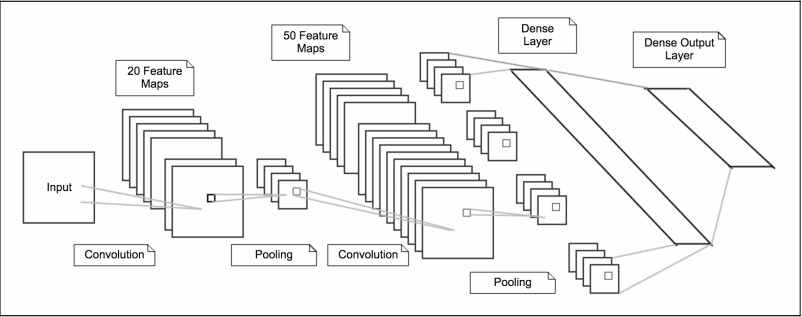

And now, let us review the code.

In [ ]:
#define the convnet 
class LeNet:
	@staticmethod
	def build(input_shape, classes):
		model = Sequential()
		# CONV => RELU => POOL
		model.add(Conv2D(20, kernel_size=5, padding="same",
			input_shape=input_shape))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
		# CONV => RELU => POOL
		model.add(Conv2D(50, kernel_size=5, padding="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
		# Flatten => RELU layers
		model.add(Flatten())
		model.add(Dense(500))
		model.add(Dropout(0.3))
		model.add(Activation("relu"))
 
		# a softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		return model


And now, let us train the model.

## 5. Train the model without data augmentation

In [ ]:

NB_EPOCH = 20
BATCH_SIZE = 128
VERBOSE = 1
OPTIMIZER = Adam()
VALIDATION_SPLIT=0.2 # For validation with 20 percent of the training data.

IMG_ROWS, IMG_COLS = 28, 28 # input image dimensions
NB_CLASSES = 10  # number of outputs = number of digits
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, 1)


Before making network ready for training we have to make sure to add below things:

1. **A loss function:** to measure how good the network is

2. **An optimizer:** to update network as it sees more data and reduce loss value

3. **Metrics:** to monitor performance of network


In [ ]:
# initialize the optimizer and model
model = LeNet.build(input_shape=INPUT_SHAPE, classes=NB_CLASSES)
model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,
	metrics=["accuracy"])


In [ ]:
history = model.fit(X_train, Y_train, 
		batch_size=BATCH_SIZE, epochs=NB_EPOCH, 
		verbose=VERBOSE, validation_split=VALIDATION_SPLIT)


## 6. Train the model using data augmentation
   one of the most commun tehnique to avoid overfitting is **data augmentation**. And We know that overfitting is generaly occur when we don't have enought data for training the model. To avoid this overfitting problem, we need to expand artificially our handwritten digit dataset. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit. 
    Also, in order to make the optimizer converge faster and closest to the global minimum of the loss function, we used an annealing method of the learning rate (LR). The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.
    Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

Different data aumentation techniques are as follows:
1. Cropping
2. Rotating
3. Scaling
4. Translating
5. Flipping
6. Adding Gaussian noise to input images etc.


Ok lets get started with data augmentation review code.

In [ ]:
# Set a learning rate annealer
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

# split the dataset to reserve a validation dataset.
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

# data generator.
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  


datagen.fit(X_train)

For the data augmentation, we choosed to :
* Randomly rotate some training images by 10 degrees
* Randomly Zoom by 10% some training images
* Randomly shift images horizontally by 10% of the width
* Randomly shift images vertically by 10% of the height

I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Now, lets fit the training data.

In [ ]:
NB_EPOCH = 30
BATCH_SIZE = 128
VERBOSE = 1
model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,
	metrics=["accuracy"])

# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=BATCH_SIZE),
                              epochs = NB_EPOCH, validation_data = (X_val,Y_val),
                              verbose = VERBOSE, steps_per_epoch=X_train.shape[0] // BATCH_SIZE
                              , callbacks=[lr_reduction])

## 7. Evaluate the model ( Model with data augmentation)

### Training and validation curves.

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

As we can look with this visualization, our model don't overfit after 30 epochs. We can increse the nomber off epochs without causing overfitting but the performance of our model don't increse significantly. 

### Confusion matrix

Confusion matrix can be very helpfull to see your model drawbacks.
We plot the confusion matrix of the validation results.


In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

### Miss-labeled data visualization

In [ ]:
# Display some error results 

errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 3
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 9 errors 
most_important_errors = sorted_dela_errors[-9:]

# Show the top 9 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## 8. Prediction

In [ ]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")


## 9. Submision.

In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("LeNet_mnist_datagen.csv",index=False)


Hope that you find this notebook helpful for you. More to come.

Please upvote if you find it useful. That will keep me motivated for doing more better.

Thanks.